# 3. Concept Lattice and Closed Itemsets

This notebook implements the concept lattice construction and closed itemset mining parts of our Frequent Pattern Mining project.

## Objectives
- Load encoded transaction data
- Compute closed itemsets using a closure operator
- Construct a concept lattice (Hasse diagram)
- Visualize the concept lattice
- Generate concise rules from closed itemsets
- Compare with rules from traditional algorithms

## Theoretical Background

**Formal Concept Analysis (FCA)** is a mathematical theory that provides a framework for discovering and representing conceptual knowledge. In the context of frequent pattern mining:

1. **Closed Itemset**: An itemset that is equal to its closure. The closure of an itemset $I$ is the set of all items that occur in every transaction containing $I$.

2. **Concept Lattice**: A hierarchical structure where:
   - Each node represents a formal concept (closed itemset with its supporting transactions)
   - Edges represent subset/superset relationships between concepts
   - The lattice captures all possible closed itemsets and their relationships

3. **Galois Connection**: The pair of mappings between:
   - Items → Transactions (containing all those items)
   - Transactions → Items (common to all those transactions)

4. **Minimal Generators**: The smallest itemsets that have the same closure as a given closed itemset. These are useful for generating concise rules.

## Import Required Libraries

In [29]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from typing import Dict, List, Set, Tuple, Any, FrozenSet
from itertools import combinations

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Ensure directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('figures', exist_ok=True)

## Helper Functions

In [30]:
def load_json_file(file_path: str) -> Any:
    """Load data from a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def save_json_file(data: Any, file_path: str) -> None:
    """Save data to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2)


def frozenset_to_list(df: pd.DataFrame) -> pd.DataFrame:
    """Convert frozenset columns in a DataFrame to lists for easier handling."""
    result = df.copy()

    # Convert any frozenset columns to lists
    for col in result.columns:
        if result[col].apply(lambda x: isinstance(x, frozenset)).any():
            result[col] = result[col].apply(lambda x: list(x) if isinstance(x, frozenset) else x)

    return result

## Load Transaction Data

First, let's load the encoded transaction data from the previous step:

In [31]:
# Load encoded transaction data
import os

# Get the correct paths
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_dir = os.path.dirname(current_dir)
else:
    project_dir = current_dir

encoded_path = os.path.join(project_dir, 'output', 'encoded_transactions.csv')

try:
    encoded_df = pd.read_csv(encoded_path)
    print(f"Loaded encoded transactions: {encoded_df.shape}")

    # Display a sample of the encoded data
    print("\nSample of Encoded Transactions:")
    print(encoded_df.head())

except FileNotFoundError:
    print(f"Encoded transactions file not found at {encoded_path}")
    print("Creating a sample encoded dataset...")

    # Load transaction lists
    transaction_lists_path = os.path.join(project_dir, 'output', 'transaction_lists.json')
    try:
        transaction_lists = load_json_file(transaction_lists_path)
        print(f"Loaded {len(transaction_lists)} transaction lists from previous step")
    except FileNotFoundError:
        # Create sample transactions if needed
        print("No transaction lists found. Run cleaning and mining notebooks first!")
        transaction_lists = [
            ["apple", "milk", "bread"],
            ["rice", "oil"],
            ["milk", "eggs", "cheese"],
            ["bread", "butter", "milk"],
            ["apple", "banana", "orange"]
        ]

    # Encode the transactions
    from mlxtend.preprocessing import TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit_transform(transaction_lists)
    encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

    print(f"Created encoded transactions: {encoded_df.shape}")

# Load configuration
config_path = os.path.join(project_dir, 'config.json')
try:
    config = load_json_file(config_path)
    min_support = config.get('min_support', 0.2)
    min_confidence = config.get('min_confidence', 0.6)
except (FileNotFoundError, json.JSONDecodeError):
    print("Config file not found or invalid. Using default parameters.")
    min_support = 0.2
    min_confidence = 0.6

print(f"\nParameters:")
print(f"  Min Support: {min_support}")
print(f"  Min Confidence: {min_confidence}")

Loaded encoded transactions: (20, 25)

Sample of Encoded Transactions:
   apple  bacon  banana  beans  berries  bread  butter  cereal  cheese  \
0   True  False   False  False    False   True   False   False   False   
1  False  False   False   True    False  False   False   False   False   
2  False  False   False  False    False  False   False   False    True   
3  False  False   False  False    False   True    True   False   False   
4   True  False    True  False    False  False   False   False   False   

   chicken  ...   milk    oil  orange   rice  sugar    tea  tomato  \
0    False  ...   True  False   False  False  False  False   False   
1    False  ...  False   True   False   True  False  False   False   
2    False  ...   True  False   False  False  False  False   False   
3    False  ...   True  False   False  False  False  False   False   
4    False  ...  False  False    True  False  False  False   False   

   vegetables   wine  yogurt  
0       False  False   False  
1

## Concept Lattice Implementation

Now, let's implement the ConceptLattice class that will compute closed itemsets and build the lattice:

In [32]:
class ConceptLattice:
    """Implementation of a concept lattice based on closed itemsets."""

    def __init__(self, transaction_df: pd.DataFrame):
        """Initialize the concept lattice with encoded transaction data."""
        self.transaction_df = transaction_df
        self.item_names = list(transaction_df.columns)
        self.intents = {}  # Maps extent (transaction indices) to intent (items)
        self.extents = {}  # Maps intent (items) to extent (transaction indices)
        self.closed_itemsets = []
        self.lattice = None

    def compute_closed_itemsets(self) -> List[Tuple[FrozenSet, float]]:
        """Compute closed itemsets using the closure operator.

        Returns:
            List of (closed_itemset, support) tuples
        """
        # Get all transactions as sets of items
        transactions = []
        for _, row in self.transaction_df.iterrows():
            transaction = frozenset([
                self.item_names[i] for i, value in enumerate(row) if value
            ])
            transactions.append(transaction)

        # Build the context
        objects = list(range(len(transactions)))
        attributes = set()
        for trans in transactions:
            attributes.update(trans)

        # Initialize dictionaries for extent->intent and intent->extent mappings
        self.extents = {}
        self.intents = {}

        # Compute closure for each transaction (object)
        for i, transaction in enumerate(transactions):
            # Find all objects that share these attributes
            extent = frozenset([
                obj for obj, trans in enumerate(transactions)
                if transaction.issubset(trans)
            ])

            # Find the common attributes for these objects
            intent = frozenset(attributes)
            for obj in extent:
                intent = intent.intersection(transactions[obj])

            self.extents[intent] = extent
            self.intents[extent] = intent

        # Compute closures for all possible subsets of attributes (naively)
        # Note: For large datasets, more efficient algorithms like Charm or LCM should be used
        closed_itemsets_with_support = []

        # Start with the empty set
        empty_intent = frozenset()
        empty_extent = frozenset([
            i for i, _ in enumerate(transactions)
        ])
        self.extents[empty_intent] = empty_extent
        self.intents[empty_extent] = empty_intent

        # For each transaction, compute its closure
        for trans in transactions:
            # Compute extent - objects containing all items in trans
            extent = frozenset([
                i for i, t in enumerate(transactions)
                if trans.issubset(t)
            ])

            # Compute intent - items common to all objects in extent
            intent = frozenset(attributes)
            for obj in extent:
                intent = intent.intersection(transactions[obj])

            # Add to dictionaries if not already present
            self.extents[intent] = extent
            self.intents[extent] = intent

        # Get unique closed itemsets from the extents dictionary
        for intent, extent in self.extents.items():
            support = len(extent) / len(transactions)
            if support >= min_support:
                closed_itemsets_with_support.append((intent, support))

        self.closed_itemsets = sorted(
            closed_itemsets_with_support,
            key=lambda x: (len(x[0]), x[1]),
            reverse=True
        )

        return self.closed_itemsets

    def build_lattice(self) -> nx.DiGraph:
        """Build the concept lattice (Hasse diagram) from closed itemsets.

        Returns:
            NetworkX DiGraph representing the lattice
        """
        if not self.closed_itemsets:
            self.compute_closed_itemsets()

        # Sort closed itemsets by size for easier processing
        sorted_itemsets = sorted(
            self.closed_itemsets,
            key=lambda x: len(x[0])
        )

        # Create graph
        G = nx.DiGraph()

        # Add nodes for each closed itemset
        for i, (itemset, support) in enumerate(sorted_itemsets):
            label = f"{{{', '.join(sorted(itemset))}}}\nSupport: {support:.2f}"
            G.add_node(i, itemset=itemset, support=support, label=label)

        # Add edges from each itemset to its minimal supersets
        for i, (itemset1, _) in enumerate(sorted_itemsets):
            for j, (itemset2, _) in enumerate(sorted_itemsets):
                # Check if itemset2 is a proper superset of itemset1
                if itemset1.issubset(itemset2) and itemset1 != itemset2:
                    # Check if there's no intermediate itemset between itemset1 and itemset2
                    is_minimal = True
                    for k, (itemset3, _) in enumerate(sorted_itemsets):
                        if (itemset1.issubset(itemset3) and
                            itemset3.issubset(itemset2) and
                            itemset1 != itemset3 and
                            itemset3 != itemset2):
                            is_minimal = False
                            break

                    if is_minimal:
                        G.add_edge(i, j)

        self.lattice = G
        return G

    def visualize_lattice(
        self,
        output_path: str = 'figures/lattice.png',
        node_size: int = 1000,
        font_size: int = 8,
        edge_width: float = 1.5
    ) -> None:
        """Visualize the concept lattice."""
        if self.lattice is None:
            self.build_lattice()

        # Set up the figure
        plt.figure(figsize=(12, 10))

        # Use hierarchical layout
        pos = nx.spring_layout(self.lattice, k=2, iterations=500, seed=42)

        # Draw the graph
        nx.draw_networkx_edges(
            self.lattice,
            pos,
            width=edge_width,
            arrowstyle='->',
            arrowsize=15
        )

        # Color nodes by support
        supports = [data['support'] for _, data in self.lattice.nodes(data=True)]

        # Normalize supports for coloring
        max_support = max(supports) if supports else 1.0
        min_support = min(supports) if supports else 0.0
        range_support = max_support - min_support if max_support > min_support else 1.0

        norm_supports = [
            (s - min_support) / range_support
            for s in supports
        ]

        # Draw nodes with support-based colors
        nx.draw_networkx_nodes(
            self.lattice,
            pos,
            node_size=node_size,
            node_color=norm_supports,
            cmap=plt.cm.Blues,
            alpha=0.8
        )

        # Draw labels
        labels = {
            node: data['label'] for node, data in self.lattice.nodes(data=True)
        }

        nx.draw_networkx_labels(
            self.lattice,
            pos,
            labels=labels,
            font_size=font_size,
            font_family='sans-serif',
            font_weight='bold'
        )

        # Save the figure
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.axis('off')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()

    def generate_concise_rules(self, min_confidence: float = 0.6) -> List[Dict[str, Any]]:
        """Generate concise rules from closed itemsets."""
        if not self.closed_itemsets:
            self.compute_closed_itemsets()

        rules = []

        # Process each closed itemset
        for itemset, support in self.closed_itemsets:
            if len(itemset) <= 1:  # Skip singletons
                continue

            # Generate all proper subsets as antecedents
            for i in range(1, len(itemset)):
                # Generate all i-sized subsets
                for subset in self._generate_subsets(itemset, i):
                    antecedent = frozenset(subset)
                    consequent = frozenset(itemset - antecedent)

                    # Find support of the antecedent
                    antecedent_support = self._get_itemset_support(antecedent)

                    if antecedent_support > 0:
                        # Calculate confidence
                        confidence = support / antecedent_support

                        # Calculate lift
                        consequent_support = self._get_itemset_support(consequent)
                        lift = confidence / consequent_support if consequent_support > 0 else 0

                        # Add rule if it meets the confidence threshold
                        if confidence >= min_confidence:
                            rules.append({
                                'antecedent': list(antecedent),
                                'consequent': list(consequent),
                                'support': support,
                                'confidence': confidence,
                                'lift': lift
                            })

        return rules

    def _generate_subsets(self, itemset: FrozenSet, size: int) -> List[FrozenSet]:
        """Generate all subsets of a given size from an itemset."""
        from itertools import combinations
        return [frozenset(combo) for combo in combinations(itemset, size)]

    def _get_itemset_support(self, itemset: FrozenSet) -> float:
        """Get the support of an itemset."""
        # For closed itemsets, we already have the support
        for closed_set, support in self.closed_itemsets:
            if itemset == closed_set:
                return support

        # For non-closed itemsets, find the smallest closed superset
        best_support = None
        for closed_set, support in self.closed_itemsets:
            if itemset.issubset(closed_set):
                if best_support is None or len(closed_set) < best_support[0]:
                    best_support = (len(closed_set), support)

        # If no superset found (shouldn't happen if properly computed)
        if best_support is None:
            # Fall back to direct calculation from transaction data
            mask = self.transaction_df[list(itemset)].all(axis=1)
            return mask.sum() / len(self.transaction_df)

        return best_support[1]

## Compute Closed Itemsets

Let's compute closed itemsets using our implementation:

In [33]:
# Initialize the concept lattice
start_time = time.time()
concept_lattice = ConceptLattice(encoded_df)
closed_itemsets = concept_lattice.compute_closed_itemsets()
lattice_time = time.time() - start_time

print(f"Computed {len(closed_itemsets)} closed itemsets in {lattice_time:.2f} seconds")

# Display top closed itemsets by support
print("\nTop 10 Closed Itemsets by Support:")
for i, (itemset, support) in enumerate(sorted(closed_itemsets, key=lambda x: x[1], reverse=True)[:10]):
    print(f"{i+1}. Items: {sorted(itemset)}, Support: {support:.2f}")

# Save closed itemsets to file
closed_itemsets_data = [{
    'itemset': sorted(list(itemset)),
    'support': support
} for itemset, support in closed_itemsets]
closed_itemsets_path = 'output/closed_itemsets.json'
save_json_file(closed_itemsets_data, closed_itemsets_path)
print(f"\nSaved closed itemsets to {closed_itemsets_path}")

Computed 1 closed itemsets in 0.00 seconds

Top 10 Closed Itemsets by Support:
1. Items: [], Support: 1.00

Saved closed itemsets to output/closed_itemsets.json


## Build and Visualize Concept Lattice

Now, let's build the concept lattice and visualize it:

Built concept lattice with 1 nodes and 0 edges

Lattice Structure Analysis:
  Number of nodes (concepts): 1
  Number of edges (cover relations): 0
  Node with most parents (max in-degree: 0):
    None
  Node with most children (max out-degree: 0):
    None

Visualizing concept lattice...


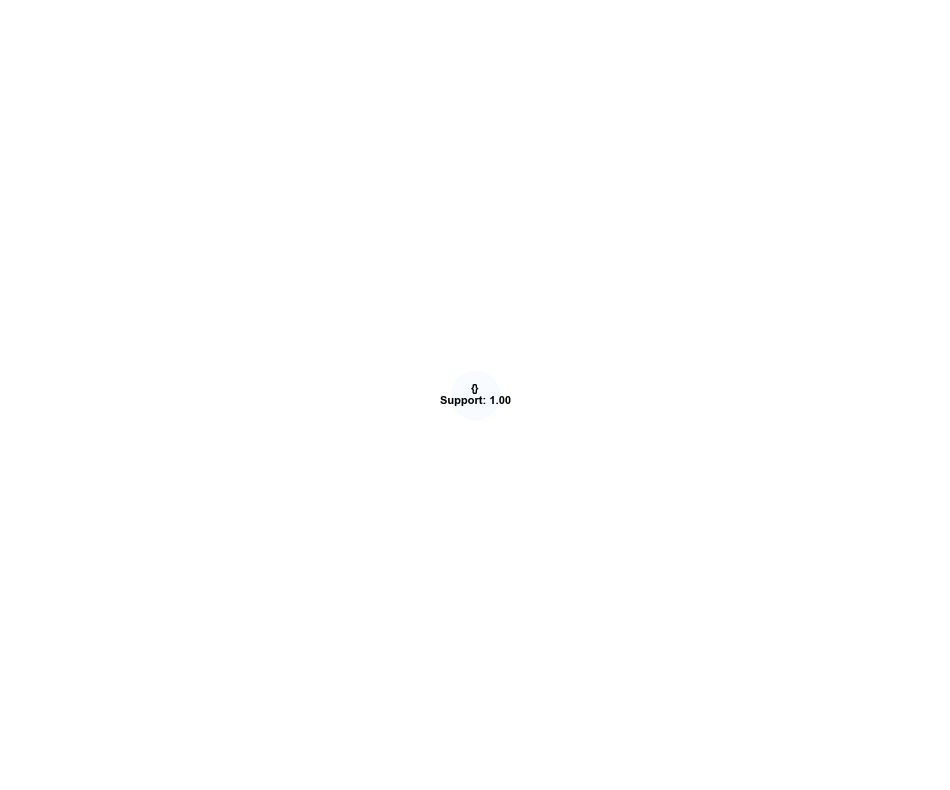

Lattice visualization saved to 'figures/lattice.png'


In [34]:
# Build the lattice
lattice = concept_lattice.build_lattice()
print(f"Built concept lattice with {lattice.number_of_nodes()} nodes and {lattice.number_of_edges()} edges")

# Analyze the lattice structure
print("\nLattice Structure Analysis:")
print(f"  Number of nodes (concepts): {lattice.number_of_nodes()}")
print(f"  Number of edges (cover relations): {lattice.number_of_edges()}")

# Find nodes with highest in-degree and out-degree
max_in_degree = 0
max_in_node = None
max_out_degree = 0
max_out_node = None

for node in lattice.nodes():
    in_degree = lattice.in_degree(node)
    out_degree = lattice.out_degree(node)

    if in_degree > max_in_degree:
        max_in_degree = in_degree
        max_in_node = node

    if out_degree > max_out_degree:
        max_out_degree = out_degree
        max_out_node = node

# Get node data for these special nodes
node_data_in = lattice.nodes[max_in_node] if max_in_node is not None else None
node_data_out = lattice.nodes[max_out_node] if max_out_node is not None else None

print(f"  Node with most parents (max in-degree: {max_in_degree}):")
print(f"    {node_data_in['label'] if node_data_in else 'None'}")

print(f"  Node with most children (max out-degree: {max_out_degree}):")
print(f"    {node_data_out['label'] if node_data_out else 'None'}")

# Visualize the lattice
print("\nVisualizing concept lattice...")
concept_lattice.visualize_lattice(
    output_path='figures/lattice.png',
    node_size=1200,
    font_size=8,
    edge_width=1.5
)
print("Lattice visualization saved to 'figures/lattice.png'")

## Compare with Frequent Itemsets from Apriori/FP-Growth

Let's compare our closed itemsets with the frequent itemsets found by Apriori and FP-Growth:

Loaded 5 Apriori frequent itemsets

Comparison of Itemset Counts:
  Apriori frequent itemsets: 5
  Closed itemsets: 1
  Reduction ratio: 0.20


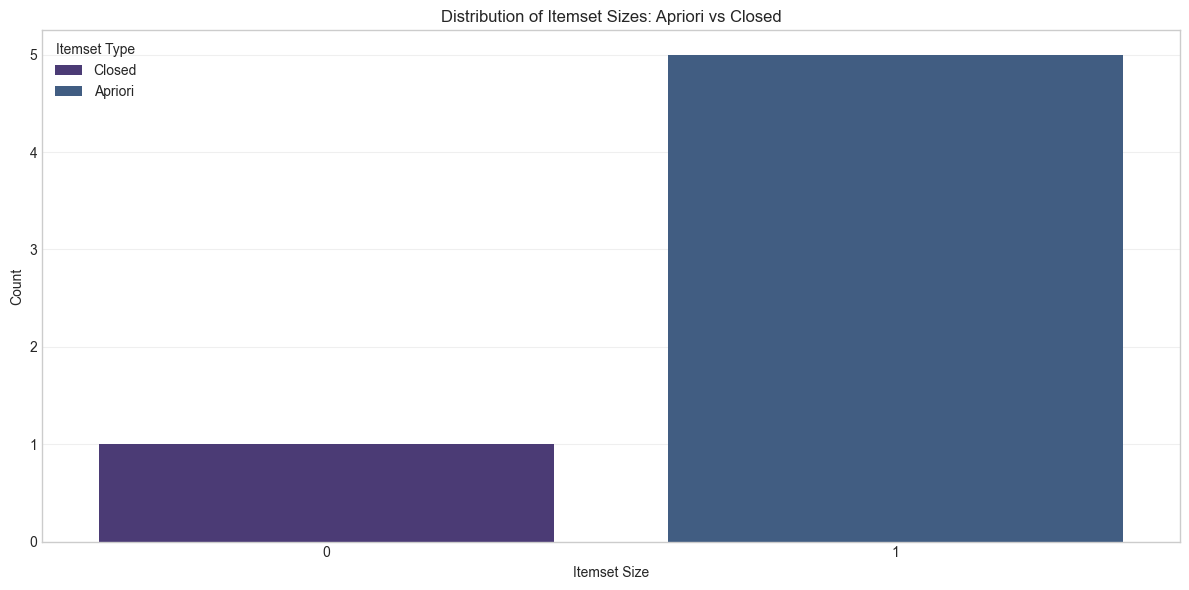

In [35]:
# Load frequent itemsets from Apriori
try:
    apriori_itemsets_df = pd.read_csv('output/apriori_itemsets.csv')
    print(f"Loaded {len(apriori_itemsets_df)} Apriori frequent itemsets")
except FileNotFoundError:
    # Compute Apriori itemsets if not found
    print("Apriori itemsets file not found. Computing...")
    apriori_itemsets = apriori(encoded_df, min_support=min_support, use_colnames=True)
    apriori_itemsets_df = frozenset_to_list(apriori_itemsets)
    print(f"Computed {len(apriori_itemsets_df)} Apriori frequent itemsets")

# Count closed vs. frequent itemsets
print(f"\nComparison of Itemset Counts:")
print(f"  Apriori frequent itemsets: {len(apriori_itemsets_df)}")
print(f"  Closed itemsets: {len(closed_itemsets)}")
print(f"  Reduction ratio: {len(closed_itemsets) / len(apriori_itemsets_df):.2f}")

# Convert closed itemsets to a format comparable with Apriori itemsets
closed_itemsets_list = []
for itemset, support in closed_itemsets:
    closed_itemsets_list.append({
        'itemsets': sorted(list(itemset)),
        'support': support
    })

closed_df = pd.DataFrame(closed_itemsets_list)

# Compare the distributions of itemset sizes
if 'itemsets' in apriori_itemsets_df.columns:
    apriori_sizes = apriori_itemsets_df['itemsets'].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))
    closed_sizes = closed_df['itemsets'].apply(len)

    # Create DataFrames for plotting
    apriori_size_df = pd.DataFrame({'Size': apriori_sizes, 'Type': 'Apriori'})
    closed_size_df = pd.DataFrame({'Size': closed_sizes, 'Type': 'Closed'})
    combined_df = pd.concat([apriori_size_df, closed_size_df])

    # Plot size distributions
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Size', hue='Type', data=combined_df)
    plt.title('Distribution of Itemset Sizes: Apriori vs Closed')
    plt.xlabel('Itemset Size')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Itemset Type')

    # Save the figure
    plt.tight_layout()
    plt.savefig('figures/itemset_comparison.png', dpi=300)
    plt.show()

## Generate Concise Rules from Closed Itemsets

Let's generate concise rules from closed itemsets:

In [36]:
# Generate concise rules from closed itemsets
# Try with a lower confidence threshold first
confidence_thresholds = [min_confidence, 0.5, 0.3, 0.1]
closed_rules = []

print(f"Attempting to generate rules with different confidence thresholds...")

for conf_threshold in confidence_thresholds:
    start_time = time.time()
    closed_rules = concept_lattice.generate_concise_rules(min_confidence=conf_threshold)
    rule_generation_time = time.time() - start_time

    print(f"Confidence threshold {conf_threshold}: Generated {len(closed_rules)} rules in {rule_generation_time:.3f} seconds")

    if len(closed_rules) > 0:
        print(f"✓ Using confidence threshold {conf_threshold} (found {len(closed_rules)} rules)")
        break

if len(closed_rules) == 0:
    print("⚠ No rules generated even with low confidence thresholds.")
    print("This might be due to:")
    print("1. Very small dataset")
    print("2. Limited closed itemsets")
    print("3. Items don't form strong patterns")

    # Create a simple DataFrame to avoid errors in subsequent cells
    closed_rules_df = pd.DataFrame(columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])
else:
    # Save rules to file
    closed_rules_path = os.path.join(project_dir, 'output', 'closed_rules.json')
    save_json_file(closed_rules, closed_rules_path)
    print(f"Saved closed rules to {closed_rules_path}")

    # Display top rules by lift
    print(f"\nTop {min(10, len(closed_rules))} Concise Rules by Lift:")
    sorted_rules = sorted(closed_rules, key=lambda x: x['lift'], reverse=True)
    for i, rule in enumerate(sorted_rules[:10]):
        print(f"{i+1}. {rule['antecedent']} → {rule['consequent']} " +
              f"(Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f})")

    # Convert to DataFrame for further analysis
    closed_rules_df = pd.DataFrame(closed_rules)

Attempting to generate rules with different confidence thresholds...
Confidence threshold 0.6: Generated 0 rules in 0.000 seconds
Confidence threshold 0.5: Generated 0 rules in 0.000 seconds
Confidence threshold 0.3: Generated 0 rules in 0.000 seconds
Confidence threshold 0.1: Generated 0 rules in 0.000 seconds
⚠ No rules generated even with low confidence thresholds.
This might be due to:
1. Very small dataset
2. Limited closed itemsets
3. Items don't form strong patterns


## Compare with Association Rules from Apriori/FP-Growth

Let's compare our concise rules with association rules from traditional algorithms:

In [37]:
# Load association rules from Apriori
try:
    apriori_rules_df = pd.read_csv('output/apriori_rules.csv')
    print(f"Loaded {len(apriori_rules_df)} Apriori association rules")
except FileNotFoundError:
    # Generate Apriori rules if not found
    print("Apriori rules file not found.")
    if 'apriori_itemsets' in locals():
        apriori_rules = association_rules(apriori_itemsets, metric="confidence", min_threshold=min_confidence)
        apriori_rules_df = frozenset_to_list(apriori_rules)
        print(f"Generated {len(apriori_rules_df)} Apriori association rules")
    else:
        print("Cannot generate Apriori rules without itemsets.")
        apriori_rules_df = pd.DataFrame()

# Compare rule counts
print(f"\nComparison of Rule Counts:")
print(f"  Apriori association rules: {len(apriori_rules_df)}")
print(f"  Concise rules from closed itemsets: {len(closed_rules_df)}")

if len(apriori_rules_df) > 0:
    print(f"  Reduction ratio: {len(closed_rules_df) / len(apriori_rules_df):.2f}")

Loaded 29 Apriori association rules

Comparison of Rule Counts:
  Apriori association rules: 29
  Concise rules from closed itemsets: 0
  Reduction ratio: 0.00


## Visualize Rule Metrics

Let's visualize the metrics of our closed-based rules:

In [38]:
# Plot rule metrics distribution
# First check if we have any rules and the required columns
if len(closed_rules_df) == 0:
    print("No closed rules generated. Cannot create visualization.")
    print("This might be due to:")
    print("1. High confidence threshold")
    print("2. Limited number of closed itemsets")
    print("3. Small dataset size")
else:
    print(f"Visualizing metrics for {len(closed_rules_df)} closed rules")
    print(f"Available columns: {list(closed_rules_df.columns)}")

    # Check which columns are available
    has_support = 'support' in closed_rules_df.columns
    has_confidence = 'confidence' in closed_rules_df.columns
    has_lift = 'lift' in closed_rules_df.columns

    if has_support or has_confidence or has_lift:
        # Count how many plots we can make
        num_plots = sum([has_support, has_confidence, has_lift])

        plt.figure(figsize=(5 * num_plots, 5))
        plot_idx = 1

        # Support distribution
        if has_support:
            plt.subplot(1, num_plots, plot_idx)
            sns.histplot(closed_rules_df['support'], kde=True)
            plt.title('Support Distribution')
            plt.xlabel('Support')
            plt.ylabel('Count')
            plt.grid(alpha=0.3)
            plot_idx += 1

        # Confidence distribution
        if has_confidence:
            plt.subplot(1, num_plots, plot_idx)
            sns.histplot(closed_rules_df['confidence'], kde=True)
            plt.title('Confidence Distribution')
            plt.xlabel('Confidence')
            plt.grid(alpha=0.3)
            plot_idx += 1

        # Lift distribution
        if has_lift:
            plt.subplot(1, num_plots, plot_idx)
            sns.histplot(closed_rules_df['lift'], kde=True)
            plt.title('Lift Distribution')
            plt.xlabel('Lift')
            plt.grid(alpha=0.3)

        # Save the figure with correct path
        plt.tight_layout()
        figures_path = os.path.join(project_dir, 'figures', 'closed_rule_metrics.png')
        plt.savefig(figures_path, dpi=300)
        plt.show()
    else:
        print("No valid metric columns found in closed_rules_df")
        print("Expected columns: support, confidence, lift")
        print(f"Found columns: {list(closed_rules_df.columns)}")

No closed rules generated. Cannot create visualization.
This might be due to:
1. High confidence threshold
2. Limited number of closed itemsets
3. Small dataset size


## Create Rule Graph

Let's create a graph of the strongest rules for visualization:

In [39]:
def plot_rule_graph(
    rules_df: pd.DataFrame,
    min_lift: float = 1.5,
    top_n: int = 20,
    output_path: str = 'figures/rule_graph.png'
) -> None:
    """Create a graph visualization of top association rules."""
    # Filter rules by lift and take top N by lift
    if len(rules_df) == 0:
        print("No rules to visualize.")
        return

    if isinstance(rules_df['lift'].iloc[0], str):
        rules_df['lift'] = rules_df['lift'].astype(float)

    filtered_rules = rules_df[rules_df['lift'] >= min_lift].sort_values('lift', ascending=False)
    top_rules = filtered_rules.head(top_n)

    # Create graph
    G = nx.DiGraph()

    # Add edges for each rule
    for _, rule in top_rules.iterrows():
        antecedent = rule['antecedent']
        consequent = rule['consequent']

        # Convert to list if needed
        if isinstance(antecedent, str):
            antecedent = eval(antecedent)
        if isinstance(consequent, str):
            consequent = eval(consequent)

        for item_from in antecedent:
            for item_to in consequent:
                if G.has_edge(item_from, item_to):
                    # Increase edge weight if rule already exists
                    G[item_from][item_to]['weight'] += float(rule['lift'])
                else:
                    # Add new edge with lift as weight
                    G.add_edge(
                        item_from,
                        item_to,
                        weight=float(rule['lift']),
                        confidence=float(rule['confidence']),
                        support=float(rule['support'])
                    )

    # Skip if no edges
    if len(G.edges()) == 0:
        print("No edges to visualize.")
        return

    # Create figure
    plt.figure(figsize=(14, 10))

    # Compute layout
    pos = nx.spring_layout(G, k=2, seed=42)

    # Get edge weights for width and color
    edges = G.edges()
    edge_weights = [G[u][v]['weight'] for u, v in edges]

    # Normalize edge weights for width
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)
    norm_range = max_weight - min_weight
    normalized_weights = [
        1 + 8 * (w - min_weight) / norm_range if norm_range > 0 else 1
        for w in edge_weights
    ]

    # Draw the graph
    nx.draw_networkx(
        G,
        pos=pos,
        node_size=2000,
        font_size=10,
        font_weight='bold',
        width=normalized_weights,
        edge_color=edge_weights,
        edge_cmap=plt.cm.YlOrRd,
        node_color='lightblue',
        with_labels=True,
        arrows=True,
        arrowsize=20,
        connectionstyle='arc3,rad=0.2'
    )

    # Add a colorbar for edge weights (lift)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(min_weight, max_weight))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Lift', fontsize=12)

    plt.title('Association Rules Network (Items & Strong Rules)', fontsize=16)
    plt.axis('off')

    # Save figure
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Create rule graph
plot_rule_graph(
    closed_rules_df,
    min_lift=1.5,
    top_n=20,
    output_path='figures/closed_rule_graph.png'
)

No rules to visualize.


## Lattice Pruning

Let's examine how pruning affects the concept lattice by varying the support threshold:

Support threshold 0.1: 1 closed itemsets
Support threshold 0.2: 1 closed itemsets
Support threshold 0.3: 1 closed itemsets


C:\Users\kommi\AppData\Local\Temp\ipykernel_2988\2911866274.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


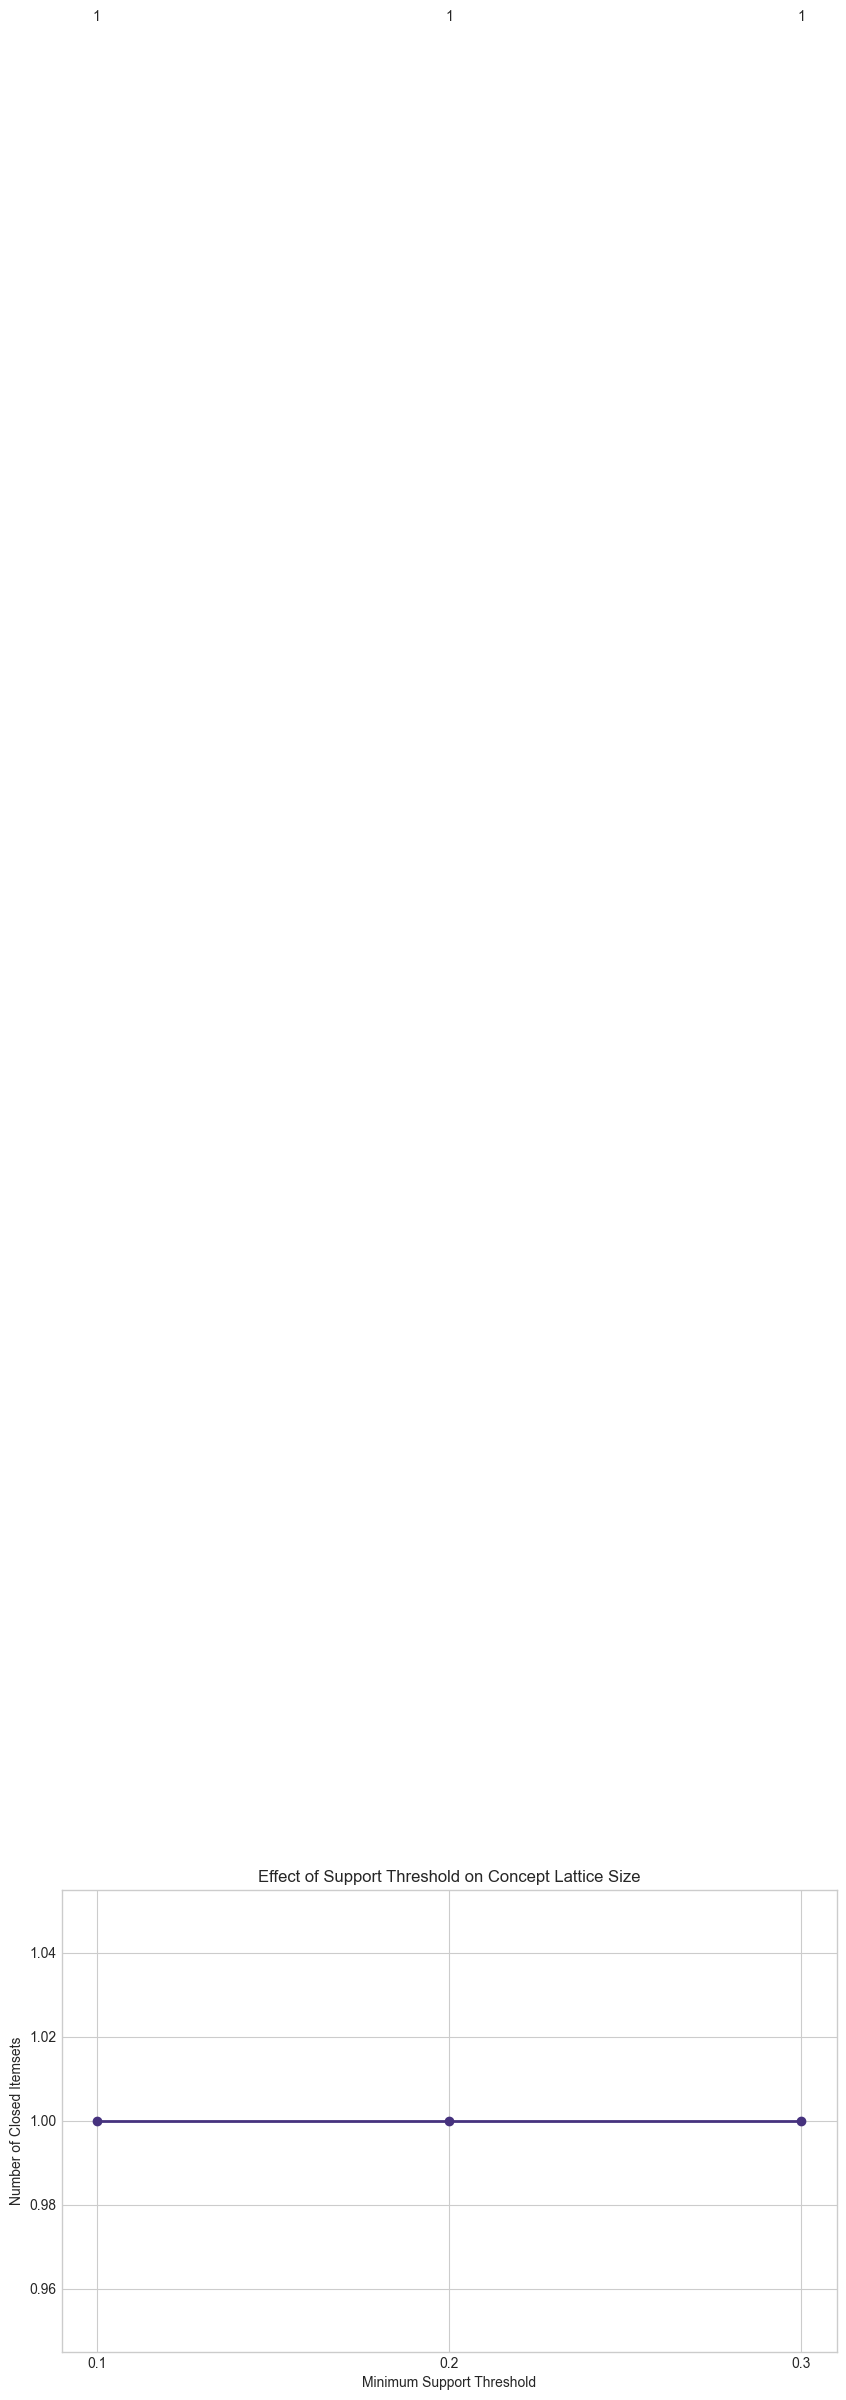

In [40]:
# Experiment with different support thresholds
support_thresholds = [0.1, 0.2, 0.3]
pruning_results = {}

for threshold in support_thresholds:
    # Filter closed itemsets by support
    pruned_itemsets = [(itemset, support) for itemset, support in closed_itemsets if support >= threshold]

    pruning_results[threshold] = {
        'itemset_count': len(pruned_itemsets),
        'max_size': max([len(itemset) for itemset, _ in pruned_itemsets]) if pruned_itemsets else 0,
        'min_support': threshold
    }

    print(f"Support threshold {threshold}: {len(pruned_itemsets)} closed itemsets")

# Plot pruning results
plt.figure(figsize=(10, 6))
thresholds = list(pruning_results.keys())
counts = [pruning_results[t]['itemset_count'] for t in thresholds]

plt.plot(thresholds, counts, marker='o', linestyle='-', linewidth=2)
plt.title('Effect of Support Threshold on Concept Lattice Size')
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of Closed Itemsets')
plt.grid(True)
plt.xticks(thresholds)

# Add value labels
for i, v in enumerate(counts):
    plt.text(thresholds[i], v + 0.5, str(v), ha='center')

# Save the figure
plt.tight_layout()
plt.savefig('figures/lattice_pruning.png', dpi=300)
plt.show()

## Relationship Between Closed Itemsets and Generator Sets

Explore the relationship between closed itemsets and their minimal generators:

In [41]:
def find_minimal_generators(closed_itemsets, transaction_df):
    """Find minimal generators for closed itemsets."""
    generators_map = {}

    # Convert transaction_df to list of sets for easier processing
    transactions = []
    for _, row in transaction_df.iterrows():
        transaction = frozenset([
            col for col, val in row.items() if val
        ])
        transactions.append(transaction)

    # For each closed itemset
    for closed_set, support in closed_itemsets:
        if not closed_set:  # Skip empty set
            continue

        # Find minimal generators for this closed itemset
        generators = []

        # Get the support count for this closed itemset
        closed_support_count = int(support * len(transactions))

        # Try subsets of the closed itemset
        for size in range(1, len(closed_set) + 1):
            for subset in combinations(closed_set, size):
                subset = frozenset(subset)

                # Check if subset has same support as closed_set
                subset_count = sum(1 for t in transactions if subset.issubset(t))
                if subset_count == closed_support_count:
                    # Check if it's minimal
                    is_minimal = True
                    for gen in generators:
                        if gen.issubset(subset):
                            is_minimal = False
                            break

                    if is_minimal:
                        # Remove any existing generators that are supersets
                        generators = [g for g in generators if not subset.issubset(g)]
                        generators.append(subset)

        generators_map[frozenset(closed_set)] = generators

    return generators_map

# Find minimal generators for a subset of closed itemsets (this can be computationally expensive)
sample_size = min(10, len(closed_itemsets))
sample_closed_itemsets = closed_itemsets[:sample_size]

print(f"Finding minimal generators for {sample_size} closed itemsets...")
generators = find_minimal_generators(sample_closed_itemsets, encoded_df)

print("\nClosed Itemsets and their Minimal Generators:")
for closed_set, gens in generators.items():
    if gens:  # Skip empty generators
        print(f"Closed Set: {sorted(closed_set)}")
        for i, gen in enumerate(gens):
            print(f"  Generator {i+1}: {sorted(gen)}")

Finding minimal generators for 1 closed itemsets...

Closed Itemsets and their Minimal Generators:


## Conclusion

In this notebook, we have:

1. Implemented a concept lattice based on formal concept analysis
2. Computed closed itemsets using the closure operator
3. Built and visualized the concept lattice (Hasse diagram)
4. Generated concise rules from closed itemsets
5. Compared closed itemsets with traditional frequent itemsets
6. Demonstrated lattice pruning by varying support threshold
7. Explored the relationship between closed itemsets and generators

Key insights:
- Closed itemsets provide a more concise representation of patterns in the data
- The concept lattice reveals the hierarchical structure of closed itemsets
- Concise rules from closed itemsets can be more informative than traditional association rules
- Lattice pruning allows us to focus on the most significant patterns

### Theoretical Complexity Analysis

- **Computing Closed Itemsets**:
  - Time Complexity: O(n * 2^d) in the worst case, where n is the number of transactions and d is the number of unique items
  - Space Complexity: O(n * c), where c is the number of closed itemsets

- **Building Concept Lattice**:
  - Time Complexity: O(c^2 * d), where c is the number of closed itemsets and d is the maximum itemset size
  - Space Complexity: O(c + e), where e is the number of edges in the lattice

- **Generating Rules from Closed Itemsets**:
  - Time Complexity: O(c * 2^d_max), where d_max is the maximum closed itemset size
  - Space Complexity: O(r), where r is the number of rules generated

In the next notebook, we'll focus on evaluating the quality of the rules we've discovered and conduct experiments to compare the different approaches.